# Molecular Isotopic Distributions Part 1: Enumerating Isotopic Placements

Elements can have several [isotopes](https://en.wikipedia.org/wiki/Isotope), which have the same number of protons and neutrons but different numbers of neutrons. Because a neutron has a mass of approximately 1 amu (atomic mass unit), different isotopes of an element appear at different masses in a mass spectrum as measured by a mass spectrometer.

Different elements have different isotopes and different natural abundances, meaning the percent of each isotope that is found in nature. For example, [carbon has two stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_carbon), <sup>12</sup>C with 98.9% natural abundance and <sup>13</sup>C with 1.06% natural abundance. As another example, [oxygen has three stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_oxygen), <sup>16</sup>O with 99.8% natural abundance, <sup>17</sup>O with 0.0380% natural abundance, and <sup>18</sup>O with 0.205% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. As another example, [chlorine has two stable isotopes with significant natural abundance](https://en.wikipedia.org/wiki/Isotopes_of_chlorine), <sup>35</sup>Cl with 76% natural abundance, and <sup>37</sup>O with 24% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. 

When atoms combine into molecules, the mass distributions get richer. For example, in the diatomic molecule chlorine Cl<sub>2</sub>, which has two chlorine atoms, there are three possible molecular isotopes:

In [3]:
# !pip install rdkit
# !pip install mendeleev

In [4]:
from collections import defaultdict
import hashlib
import json

from IPython.display import display, Markdown
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl

import mendeleev
from rdkit import Chem
from rdkit.Chem import Descriptors

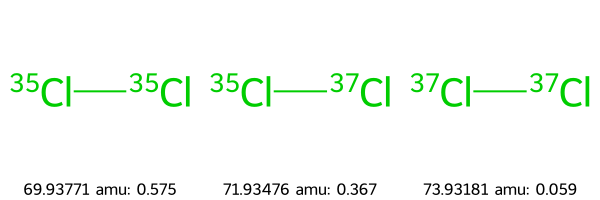

In [5]:
chlorine_smls = ["[35Cl][35Cl]", "[35Cl][37Cl]", "[37Cl][37Cl]"]
chlorine_mols = [Chem.MolFromSmiles(sml) for sml in chlorine_smls]
chlorine_masses = [Descriptors.ExactMolWt(mol) for mol in chlorine_mols]
chlorine_abundances = [0.574564, 0.366872, 0.058564]
legends = [f"{mass:.5f} amu: {abundance:.3f}" for mass, abundance in zip(chlorine_masses, chlorine_abundances)]
legends
Chem.Draw.MolsToGridImage(chlorine_mols, legends=legends)

The molecule <sup>35</sup>Cl<sup>37</sup>Cl in the middle, with mixed isotopes, represents two possible placements of the isotopes: it is equivalent to <sup>37</sup>Cl<sup>35</sup>Cl because the order of the chlorine atoms is not significant due to symmetry. The code to generate such molecules, masses, abundance, and images will be given in this blog post and the next.

In part 1, I use the naive method of creating a molecule for each possible arrangement of isotopes ([permutation](https://en.wikipedia.org/wiki/Permutation)) of a molecule. I hazily recalled that I could
- enumerate the [combinations](https://en.wikipedia.org/wiki/Combination), where the order of the isotopes over the atoms in a molecule is disregarded, and 
- calculate the permutations in each combination using the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to calculate the number of arrangements of a given number of each isotope ([isotopomer](https://en.wikipedia.org/wiki/Isotopomer)),

but I decided to first try the approach that was easier to code. However, I learned that became computationally infeasible for large molecules: for example, assigning isotopes for all permutations of napthlene, C<sub>10</sub>H<sub>8</sub>, where each element has [two isotopes and there are thus 2<sup>18</sup> = 262,144 permutations](https://en.wikipedia.org/wiki/Power_of_two#Table_of_values), took 110 seconds. So I used the combinations approach in part 2.

## Set up

In [6]:
# Carbon tetrachloride
sml = "ClC(Cl)(Cl)Cl"

Because RDKit excludes hydrogen atoms by default, but we want to assign isotopes to any hydrogen atoms in our molecule, we tell RDKit to add hydrogens.

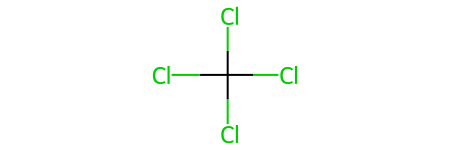

In [7]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

Next we define a `MolecularIsotope` class to store an RDKit molecule along with an abundance. (If we didn't need to store the abundance, we could simply use RDKit mol and extract the exact mass.)

In [8]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml))
    except:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml, sanitize=False))
    self.mass = Descriptors.ExactMolWt(self.mol)
    
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

Next we create a utility function to get the set of elements in a molecule.

In [9]:
def element_set(molecule):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :returns: A set.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [10]:
set_of_elements = element_set(mol)
print(set_of_elements)

{'C', 'Cl'}


Now we can create a data structure to hold the isotopic abundances of each element in our molecule. We get the abundances from the [Mendeleev](https://pypi.org/project/mendeleev/) package, filtering to those isotopes whose abundance is not `None`.

In [12]:
isotopes = {}
for element_symbol in set_of_elements:
  element_isotopes = mendeleev.element(element_symbol).isotopes
  occurring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[element_symbol] = occurring_isotopes
print(isotopes)

{'C': [[12, 0.9894], [13, 0.0106]], 'Cl': [[35, 0.758], [37, 0.242]]}


In [13]:
# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

# Create the empty numpy ndarray with the shape of the number of isotopes for each atom
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

## Setting the isotope of each atom in each permutation

Now we come to the key operation: Setting the isotope of each atom in a molecule, for each permutation.

To get a sense of the scale of the operation, let's calculate how many permutations (isotopologues) we'll have to assign isotopes to.

In [14]:
mol_isotopes.size

32

In the NumPy array, there is a dimension for each atom (five) in the molecule, and the length of each dimension is the number of isotopes for the element of that atom (two for all elements here, namely C and Cl):

In [15]:
mol_isotopes.shape

(2, 2, 2, 2, 2)

The `set_isotopes` function assigns isotopes to all elements in a multi-dimensional ndarray by
- recursively traversing down the ndarray until it comes to an individual element, not another (nested) ndarray
- creating the MolecularIsotope object, including its RDKit molecule
- for each atom,
    - assigning the isotope by referring to the `isotopes` array
    - assigning its abundance
    - calculating the overall abundance as the product of each of the atom's abundances
- calling the MolecularIsotope.update() method to set the exact mass

In [16]:
def set_isotopes(arr:np.ndarray, sml: str, current_index=()):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray, create molecule, 
        # set the isotopes of each of its atoms, and calculate abundance
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance          
        return item

Let's set the isotope of each atom in the molecule for each permutation.

In [17]:
# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

Because we're creating each permutation, we'll have to aggregate the isotopomers, analogous to matching up <sup>35</sup>Cl<sup>37</sup>Cl and <sup>37</sup>Cl<sup>35</sup>Cl.

It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the [mass numbers](https://en.wikipedia.org/wiki/Mass_number) is the same), so adding a tolerance risks lumping different isotopologues together. So it's best to use a non-numerical identifier. In this case, we use the composition, which contains isotope labels. In particular, we
- use a nested dictionary where the first level key is the element e.g. Cl, and the second level is the isotope:count, for example 35:4 indicates that <sup>35</sup>Cl appears four times in the molecule
- convert to [JSON](https://en.wikipedia.org/wiki/JSON), sorting the keys to ensure a consistent order
- hash the result using `hash_nested_dict()`, below, to create a single string for comparison.

In [18]:
def composition(
        molecule: Chem.Mol,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            # If isotopes not requested, simply count the number of atoms of each element
            if not isotopes:
                comp[element_symbol] += 1
            # If isotopes requested, count the number of each isotope of each element
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

In [19]:
ethanol = Chem.AddHs(Chem.MolFromSmiles("CCO"))

In [20]:
ethanol_isotope = Chem.AddHs(Chem.MolFromSmiles("[13CH3]CO"))

In [21]:
composition(ethanol_isotope)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': 2, 'O': 1, 'H': 6})

In [22]:
composition(ethanol_isotope, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {13: 1, 0: 1}),
             'O': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1}),
             'H': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 6})})

To make it easier to compare isotopic variations, we'll flatten the ndarray.

In [23]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [24]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)

Here's the composition dictionary for one isotopologue of our molecule:

In [25]:
composition(mol_isotopes_flat[0].mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {35: 4}),
             'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {12: 1})})

In [26]:
def hash_nested_dict(d):
    # Convert the nested dictionary to a JSON string with sorted keys
    json_str = json.dumps(d, sort_keys=True)

    # Hash the JSON string using a cryptographic hash function (e.g., SHA-256)
    hash_obj = hashlib.sha256()
    hash_obj.update(json_str.encode())
    return hash_obj.hexdigest()

In [27]:
def dict_list_to_markdown_table(data, number_rows=False):
    """
    Convert a list of dictionaries into a Markdown table.

    Args:
        data (list): A list of dictionaries, where each dictionary corresponds to a row in the table.
        include_row_numbers (bool): Whether to include a row number column.

    Returns:
        str: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table


In [28]:
# def smiles_to_formatted_formula(smiles, isotopes=False):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is not None:
#         comp = composition(mol, isotopes)

#         isotopes = defaultdict(lambda: defaultdict(str))
#         subscripts = defaultdict(lambda: defaultdict(int))
#         superscripts = defaultdict(list)

#         for element, counts in comp.items():
#             for isotope, count in counts.items():
#                 if count > 1:
#                     subscripts[element][isotope] = count
#                 if isotope != 0:
#                     superscripts[element].append(isotope)

#                 isotopes[element][isotope] = 1
#             # Sort the element's isotopes from lowest to highest
#             superscripts[element].sort()

#         formula = {'markdown': "", 'dollar_math': ""}
#         sorted_element_keys = sorted(isotopes.keys())
#         for element in sorted_element_keys:
#             isotope_count_pairs = isotopes[element]
#             # Sort the element's isotopes from lowest to highest
#             sorted_isotope_keys = sorted(isotope_count_pairs.keys())
#             for isotope in sorted_isotope_keys:
#                 if element in superscripts:
#                     if isotope in superscripts[element]:
#                         formula["markdown"] += f"<sup>{isotope}</sup>"
#                         formula["dollar_math"] += r"$^{{{}}}$".format(isotope)
#                 formula["markdown"] += element
#                 formula["dollar_math"] += r"{}".format(element)
#                 if element in subscripts:
#                     if isotope in subscripts[element]:
#                         for isotope, isotope_count in subscripts[element].items():
#                             formula["markdown"] += f"<sub>{isotope_count}</sub>"
#                             formula["dollar_math"] += r"$_{{{}}}$".format(isotope_count)
#         return formula
#     else:
#         return "Invalid SMILES"

In [60]:
def smiles_to_formatted_formula(smiles, isotopes=False):
    print(f"Running smiles_to_formatted_formula {smiles}")
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        comp = composition(mol, isotopes)

        formula = {'markdown': "", 'dollar_math': "", 'latex': ""}

        if isotopes:
            isotopes_dict = defaultdict(lambda: defaultdict(str))
            subscripts = defaultdict(lambda: defaultdict(int))
            superscripts = defaultdict(list)

            for element, counts in comp.items():
                for isotope, count in counts.items():
                    if count > 1:
                        subscripts[element][isotope] = count
                    if isotope != 0:
                        superscripts[element].append(isotope)

                    isotopes_dict[element][isotope] = 1
                # Sort the element's isotopes from lowest to highest
                superscripts[element].sort()

            sorted_element_keys = sorted(isotopes_dict.keys())
            for element in sorted_element_keys:
                isotope_count_pairs = isotopes_dict[element]
                # Sort the element's isotopes from lowest to highest
                sorted_isotope_keys = sorted(isotope_count_pairs.keys())
                for isotope in sorted_isotope_keys:
                    if element in superscripts:
                        if isotope in superscripts[element]:
                            formula["markdown"] += f"<sup>{isotope}</sup>"
                            formula["dollar_math"] += r"$^{{{}}}$".format(isotope)
                            formula["latex"] += "^{{{}}}".format(isotope)
                    formula["markdown"] += element
                    formula["dollar_math"] += r"{}".format(element)
                    formula["latex"] += element
                    if element in subscripts:
                        if isotope in subscripts[element]:
                            isotope_count = subscripts[element][isotope]
                            formula["markdown"] += f"<sub>{isotope_count}</sub>"
                            formula["dollar_math"] += r"$_{{{}}}$".format(isotope_count)
                            formula["latex"] += "_{{{}}}".format(isotope_count)
            formula["latex"] = "$" + formula["latex"] + "$"
        else:
            # Handling the case when isotopes is False
            sorted_element_keys = sorted(comp.keys())

            for element in sorted_element_keys:
                count = comp[element]
                formula["markdown"] += element
                formula["dollar_math"] += r"{}".format(element)
                formula["latex"] += element
                if count > 1:
                    formula["markdown"] += f"<sub>{count}</sub>"
                    formula["dollar_math"] += r"$_{{{}}}$".format(count)
                    formula["latex"] += "_{{{}}}".format(count)
            formula["latex"] = "$" + formula["latex"] + "$"

        return formula
    else:
        return "Invalid SMILES"

In [61]:
smiles_to_formatted_formula("[35Cl][12C]([35Cl])([37Cl])[37Cl]", isotopes=True)

Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([37Cl])[37Cl]


{'markdown': '<sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub>',
 'dollar_math': '$^{12}$C$^{35}$Cl$_{2}$$^{37}$Cl$_{2}$',
 'latex': '$^{12}C^{35}Cl_{2}^{37}Cl_{2}$'}

In [62]:
smiles_to_formatted_formula(Chem.MolToSmiles(mol_isotopes_flat[0].mol), isotopes=True)

Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[35Cl]


{'markdown': '<sup>12</sup>C<sup>35</sup>Cl<sub>4</sub>',
 'dollar_math': '$^{12}$C$^{35}$Cl$_{4}$',
 'latex': '$^{12}C^{35}Cl_{4}$'}

In [59]:
for mol_isotope in mol_isotopes_flat:
    # display(Markdown(smiles_to_formatted_formula(Chem.MolToSmiles(mol_isotope.mol), isotopes=True)["latex"]))
    mol_isotope.update()
    print(smiles_to_formatted_formula(Chem.MolToSmiles(mol_isotope.mol), isotopes=True)["latex"])

Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[35Cl]
$^{12}C^{35}Cl_{4}$
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[35Cl]
$^{13}C^{35}Cl_{4}$
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
$^{12}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
$^{12}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
$^{12}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
$^{12}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
$^{13}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
$^{13}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
$^{13}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
$^{13}C^{35}Cl_{3}^{37}Cl$
Running smiles_to_formatted_formula [35Cl][1

Now we prepare the data to put into a Polars dataframe. We use Polars because it's easy to aggregate based on matching a value such as composition, and very fast. We extract all properties of the MolecularIsotope, most importantly its abundance. We use `hash_nested_dict()` to prepare the string for comparison for aggregation.

In [63]:
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    mol_isotope.update()
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    composition_dict = composition(mol_isotope.mol, isotopes=True)
    hashed_composition_dict = hash_nested_dict(composition_dict)
    data_dict["composition_hash"] = str(hashed_composition_dict)
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list).select(["mass", "abundance", "composition_hash", "mol"])
df = df.with_columns(
    pl.col("mol").map_elements(lambda x: Chem.MolToSmiles(x)).alias("sml")
)
df = df.with_columns(
    pl.col("sml").map_elements(lambda x: smiles_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula")
)
df = df.select(["formula", "mass", "abundance", "composition_hash", "mol"])
display(Markdown(
    dict_list_to_markdown_table(
        df.rows(named=True),
        number_rows=True,
        )
    ))

Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[35Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[35Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([37Cl])[37Cl]
Running smiles_to_fo

| # | formula | mass | abundance | composition_hash | mol |
| --- | --- | --- | --- | --- | --- |
| 1 | <sup>12</sup>C<sup>35</sup>Cl<sub>4</sub> | 151.87541072 | 0.3266244779209824 | 4c6f83b9736ee84df311fa3259fb0d901def9ad87bea921c68aa7ed7902e2703 | <rdkit.Chem.rdchem.Mol object at 0x166175150> |
| 2 | <sup>13</sup>C<sup>35</sup>Cl<sub>4</sub> | 152.87876555999998 | 0.0034993121750176 | cdc6c3e1cafb512775ce9a4c3b0c233a2d8e6a892ebc205c0b390c8bdec0d582 | <rdkit.Chem.rdchem.Mol object at 0x166175460> |
| 3 | <sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 153.87246062999998 | 0.1042785272518176 | af9acd632f90c2e2a53510b4ed2dacfa1edc41f6d53544b80feb2676bf570aa0 | <rdkit.Chem.rdchem.Mol object at 0x1661751c0> |
| 4 | <sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 153.87246062999998 | 0.1042785272518176 | af9acd632f90c2e2a53510b4ed2dacfa1edc41f6d53544b80feb2676bf570aa0 | <rdkit.Chem.rdchem.Mol object at 0x1661750e0> |
| 5 | <sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 153.87246062999998 | 0.1042785272518176 | af9acd632f90c2e2a53510b4ed2dacfa1edc41f6d53544b80feb2676bf570aa0 | <rdkit.Chem.rdchem.Mol object at 0x1661752a0> |
| 6 | <sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 153.87246062999998 | 0.1042785272518176 | af9acd632f90c2e2a53510b4ed2dacfa1edc41f6d53544b80feb2676bf570aa0 | <rdkit.Chem.rdchem.Mol object at 0x166175850> |
| 7 | <sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 154.87581547 | 0.0011171946521823998 | 5ee727e6796405381715dc5eaaf23aa2885ad99cd8dcd5b15a44cc34a75d87a0 | <rdkit.Chem.rdchem.Mol object at 0x1661754d0> |
| 8 | <sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 154.87581547 | 0.0011171946521823998 | 5ee727e6796405381715dc5eaaf23aa2885ad99cd8dcd5b15a44cc34a75d87a0 | <rdkit.Chem.rdchem.Mol object at 0x166175540> |
| 9 | <sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 154.87581547 | 0.0011171946521824 | 5ee727e6796405381715dc5eaaf23aa2885ad99cd8dcd5b15a44cc34a75d87a0 | <rdkit.Chem.rdchem.Mol object at 0x166175620> |
| 10 | <sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 154.87581547 | 0.0011171946521824003 | 5ee727e6796405381715dc5eaaf23aa2885ad99cd8dcd5b15a44cc34a75d87a0 | <rdkit.Chem.rdchem.Mol object at 0x166175cb0> |
| 11 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.0332920891753824 | 9e5efbfce17b6a8603fdcd394c3a9d49d81882b1d8c84f3c913e404ef9d6f4ce | <rdkit.Chem.rdchem.Mol object at 0x166175230> |
| 12 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.0332920891753824 | 9e5efbfce17b6a8603fdcd394c3a9d49d81882b1d8c84f3c913e404ef9d6f4ce | <rdkit.Chem.rdchem.Mol object at 0x166175310> |
| 13 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.03329208917538239 | 9e5efbfce17b6a8603fdcd394c3a9d49d81882b1d8c84f3c913e404ef9d6f4ce | <rdkit.Chem.rdchem.Mol object at 0x166175380> |
| 14 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.0332920891753824 | 9e5efbfce17b6a8603fdcd394c3a9d49d81882b1d8c84f3c913e404ef9d6f4ce | <rdkit.Chem.rdchem.Mol object at 0x166175930> |
| 15 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.03329208917538239 | 9e5efbfce17b6a8603fdcd394c3a9d49d81882b1d8c84f3c913e404ef9d6f4ce | <rdkit.Chem.rdchem.Mol object at 0x1661758c0> |
| 16 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.03329208917538239 | 9e5efbfce17b6a8603fdcd394c3a9d49d81882b1d8c84f3c913e404ef9d6f4ce | <rdkit.Chem.rdchem.Mol object at 0x166175a10> |
| 17 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.00035667692061759995 | 06dde00c4956626a7e32900b25f88ef03b53364a73b7474043fa9d3307560995 | <rdkit.Chem.rdchem.Mol object at 0x1661755b0> |
| 18 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.0003566769206176 | 06dde00c4956626a7e32900b25f88ef03b53364a73b7474043fa9d3307560995 | <rdkit.Chem.rdchem.Mol object at 0x166175690> |
| 19 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.0003566769206176 | 06dde00c4956626a7e32900b25f88ef03b53364a73b7474043fa9d3307560995 | <rdkit.Chem.rdchem.Mol object at 0x166175700> |
| 20 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.00035667692061760006 | 06dde00c4956626a7e32900b25f88ef03b53364a73b7474043fa9d3307560995 | <rdkit.Chem.rdchem.Mol object at 0x166175d20> |
| 21 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.00035667692061760006 | 06dde00c4956626a7e32900b25f88ef03b53364a73b7474043fa9d3307560995 | <rdkit.Chem.rdchem.Mol object at 0x166175d90> |
| 22 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.00035667692061760006 | 06dde00c4956626a7e32900b25f88ef03b53364a73b7474043fa9d3307560995 | <rdkit.Chem.rdchem.Mol object at 0x166175e70> |
| 23 | <sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 157.86656045 | 0.010628872797417598 | a4439539b7e8dca87cdf0d022f416ceb85d0d77a03e89691b27bf809e88f2ba3 | <rdkit.Chem.rdchem.Mol object at 0x1661753f0> |
| 24 | <sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 157.86656045 | 0.010628872797417598 | a4439539b7e8dca87cdf0d022f416ceb85d0d77a03e89691b27bf809e88f2ba3 | <rdkit.Chem.rdchem.Mol object at 0x166175af0> |
| 25 | <sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 157.86656045 | 0.010628872797417598 | a4439539b7e8dca87cdf0d022f416ceb85d0d77a03e89691b27bf809e88f2ba3 | <rdkit.Chem.rdchem.Mol object at 0x166175b60> |
| 26 | <sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 157.86656045 | 0.010628872797417598 | a4439539b7e8dca87cdf0d022f416ceb85d0d77a03e89691b27bf809e88f2ba3 | <rdkit.Chem.rdchem.Mol object at 0x166175bd0> |
| 27 | <sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 158.86991529 | 0.0001138731065824 | fac3200efc9f88e1ea8ecf993c6c24e29f9c9ff02580f9108a138d5ff0235855 | <rdkit.Chem.rdchem.Mol object at 0x166175770> |
| 28 | <sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 158.86991529 | 0.00011387310658240001 | fac3200efc9f88e1ea8ecf993c6c24e29f9c9ff02580f9108a138d5ff0235855 | <rdkit.Chem.rdchem.Mol object at 0x166175e00> |
| 29 | <sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 158.86991529 | 0.00011387310658240001 | fac3200efc9f88e1ea8ecf993c6c24e29f9c9ff02580f9108a138d5ff0235855 | <rdkit.Chem.rdchem.Mol object at 0x166175ee0> |
| 30 | <sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 158.86991529 | 0.0001138731065824 | fac3200efc9f88e1ea8ecf993c6c24e29f9c9ff02580f9108a138d5ff0235855 | <rdkit.Chem.rdchem.Mol object at 0x166175f50> |
| 31 | <sup>12</sup>C<sup>37</sup>Cl<sub>4</sub> | 159.86361036 | 0.0033933868297823994 | c9e7ca3d90fa50e50848b94286db94ffed8ee0c5b5a79469ef69e4bae4c1b050 | <rdkit.Chem.rdchem.Mol object at 0x166175c40> |
| 32 | <sup>13</sup>C<sup>37</sup>Cl<sub>4</sub> | 160.86696519999998 | 3.6355266217599994e-05 | 20885a08f6c07dd7a21ac414959b24ac516c6944d2197f48cfbb0b08db2807b7 | <rdkit.Chem.rdchem.Mol object at 0x166175fc0> |


There are a total of 32 permutations. The number of permutations is the product of the number of isotopes over each atom. In this case there are five atoms, each each (C or Cl) has two isotopes, so 2 * 2 * 2 * 2 * 2 = 2<sup>5</sup> = 32.

## Aggregating isotopomers

The following aggregation expressions tell Polars to sum over abundance, and take the first value for other columns (besides abundance, which we're aggregating on).

In [64]:
agg_exprs = [
    pl.sum("abundance").alias("abundance")
] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition_hash", "abundance")
]
result_df = df.group_by("composition_hash").agg(agg_exprs)
result_df = result_df.with_columns(
    pl.col("mol").map_elements(lambda x: Chem.MolToSmiles(x)).alias("sml")
)
result_df = result_df.with_columns(
    pl.col("sml").map_elements(lambda x: smiles_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula"),
    pl.col("sml").map_elements(lambda x: smiles_to_formatted_formula(x, isotopes=True)["dollar_math"]).alias("formula_dollar_math"),
    pl.col("sml").map_elements(lambda x: smiles_to_formatted_formula(x, isotopes=True)["latex"]).alias("formula_latex"),
)
df_display = result_df.select(["formula", "mass", "abundance", "formula_dollar_math", "formula_latex"])
table = dict_list_to_markdown_table(
    df_display.rows(named=True),
    number_rows=True)
display(Markdown(table))

Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[35Cl]Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[35Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [37Cl][13C]([37Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([37Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([37Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[35Cl]
Running smiles_to_formatted_formula [37Cl][12C]([37Cl])([37Cl])[37Cl]
Running smiles_to_formatted_formula [35Cl][12C]([35Cl])([35Cl])[35Cl]
Running smiles_to_formatted_formula [35Cl][13C]([35Cl])([35Cl])[37Cl]
Running smiles_to_formatted_formula [37Cl][13C]([37Cl])([37Cl])[37Cl]
Running smiles_to_for

| # | formula | mass | abundance | formula_dollar_math | formula_latex |
| --- | --- | --- | --- | --- | --- |
| 1 | <sup>12</sup>C<sup>35</sup>Cl<sub>4</sub> | 151.87541072 | 0.3266244779209824 | $^{12}$C$^{35}$Cl$_{4}$ | $^{12}C^{35}Cl_{4}$ |
| 2 | <sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 154.87581547 | 0.0044687786087296 | $^{13}$C$^{35}$Cl$_{3}$$^{37}$Cl | $^{13}C^{35}Cl_{3}^{37}Cl$ |
| 3 | <sup>13</sup>C<sup>37</sup>Cl<sub>4</sub> | 160.86696519999998 | 3.6355266217599994e-05 | $^{13}$C$^{37}$Cl$_{4}$ | $^{13}C^{37}Cl_{4}$ |
| 4 | <sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>37</sup>Cl | 153.87246062999998 | 0.4171141090072704 | $^{12}$C$^{35}$Cl$_{3}$$^{37}$Cl | $^{12}C^{35}Cl_{3}^{37}Cl$ |
| 5 | <sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 155.86951054 | 0.1997525350522944 | $^{12}$C$^{35}$Cl$_{2}$$^{37}$Cl$_{2}$ | $^{12}C^{35}Cl_{2}^{37}Cl_{2}$ |
| 6 | <sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>37</sup>Cl<sub>2</sub> | 156.87286538 | 0.0021400615237056 | $^{13}$C$^{35}$Cl$_{2}$$^{37}$Cl$_{2}$ | $^{13}C^{35}Cl_{2}^{37}Cl_{2}$ |
| 7 | <sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 158.86991529 | 0.0004554924263296 | $^{13}$C$^{35}$Cl$^{37}$Cl$_{3}$ | $^{13}C^{35}Cl^{37}Cl_{3}$ |
| 8 | <sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<sub>3</sub> | 157.86656045 | 0.04251549118967039 | $^{12}$C$^{35}$Cl$^{37}$Cl$_{3}$ | $^{12}C^{35}Cl^{37}Cl_{3}$ |
| 9 | <sup>13</sup>C<sup>35</sup>Cl<sub>4</sub> | 152.87876555999998 | 0.0034993121750176 | $^{13}$C$^{35}$Cl$_{4}$ | $^{13}C^{35}Cl_{4}$ |
| 10 | <sup>12</sup>C<sup>37</sup>Cl<sub>4</sub> | 159.86361036 | 0.0033933868297823994 | $^{12}$C$^{37}$Cl$_{4}$ | $^{12}C^{37}Cl_{4}$ |


The aggregated result has 10 distinct isotopomers (combinations) compared to 32 permutations.

To verify that we calculated and aggregated abundances correctly, we check that the sum of abundances of the isotopomers is 1. (It might be very slightly different depending on the isotope data, numerical precision of operations, etc.)

In [67]:
mol_isotopes_agg_masses = df_display["mass"].to_list()
mol_isotopes_agg_abundances = df_display["abundance"].to_list()
mol_isotopes_agg_formulas = df_display["formula"].to_list()
mol_isotopes_agg_formulas_dollar_math = df_display["formula_dollar_math"].to_list()
mol_isotopes_agg_formulas_latex = df_display["formula_latex"].to_list()

In [34]:
abundance_sum = sum(mol_isotopes_agg_abundances)
print(abundance_sum)

1.0


## Plot abundance vs. mass results

To plot the results using Seaborn as abundance against mass, we convert to a pandas dataframe

In [68]:
df_pandas_all = pd.DataFrame({
    'Mass': mol_isotopes_agg_masses,
    'Abundance': mol_isotopes_agg_abundances,
    'Formula': mol_isotopes_agg_formulas,
    'Formula_dollar_math': mol_isotopes_agg_formulas_dollar_math,
    'Formula_latex': mol_isotopes_agg_formulas_latex,
})
df_pandas_all

,Mass,Abundance,Formula,Formula_dollar_math,Formula_latex
0,151.875411,0.326624,<sup>12</sup>C<sup>35</sup>Cl<sub>4</sub>,$^{12}$C$^{35}$Cl$_{4}$,$^{12}C^{35}Cl_{4}$
1,154.875815,0.004469,<sup>13</sup>C<sup>35</sup>Cl<sub>3</sub><sup>...,$^{13}$C$^{35}$Cl$_{3}$$^{37}$Cl,$^{13}C^{35}Cl_{3}^{37}Cl$
2,160.866965,0.000036,<sup>13</sup>C<sup>37</sup>Cl<sub>4</sub>,$^{13}$C$^{37}$Cl$_{4}$,$^{13}C^{37}Cl_{4}$
3,153.872461,0.417114,<sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>...,$^{12}$C$^{35}$Cl$_{3}$$^{37}$Cl,$^{12}C^{35}Cl_{3}^{37}Cl$
4,155.869511,0.199753,<sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>...,$^{12}$C$^{35}$Cl$_{2}$$^{37}$Cl$_{2}$,$^{12}C^{35}Cl_{2}^{37}Cl_{2}$
5,156.872865,0.002140,<sup>13</sup>C<sup>35</sup>Cl<sub>2</sub><sup>...,$^{13}$C$^{35}$Cl$_{2}$$^{37}$Cl$_{2}$,$^{13}C^{35}Cl_{2}^{37}Cl_{2}$
6,158.869915,0.000455,<sup>13</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<s...,$^{13}$C$^{35}$Cl$^{37}$Cl$_{3}$,$^{13}C^{35}Cl^{37}Cl_{3}$
7,157.866560,0.042515,<sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<s...,$^{12}$C$^{35}$Cl$^{37}$Cl$_{3}$,$^{12}C^{35}Cl^{37}Cl_{3}$
8,152.878766,0.003499,<sup>13</sup>C<sup>35</sup>Cl<sub>4</sub>,$^{13}$C$^{35}$Cl$_{4}$,$^{13}C^{35}Cl_{4}$
9,159.863610,0.003393,<sup>12</sup>C<sup>37</sup>Cl<sub>4</sub>,$^{12}$C$^{37}$Cl$_{4}$,$^{12}C^{37}Cl_{4}$


There can be many isotopomers with very low abundance, so we might want to limit the plot to a cutoff level of abundance to prevent a forest of short lines and colliding labels.

In [69]:
cutoff = 0.01
df_pandas = df_pandas_all.loc[df_pandas_all['Abundance'] >= cutoff]

In [70]:
df_pandas

,Mass,Abundance,Formula,Formula_dollar_math,Formula_latex
0,151.875411,0.326624,<sup>12</sup>C<sup>35</sup>Cl<sub>4</sub>,$^{12}$C$^{35}$Cl$_{4}$,$^{12}C^{35}Cl_{4}$
3,153.872461,0.417114,<sup>12</sup>C<sup>35</sup>Cl<sub>3</sub><sup>...,$^{12}$C$^{35}$Cl$_{3}$$^{37}$Cl,$^{12}C^{35}Cl_{3}^{37}Cl$
4,155.869511,0.199753,<sup>12</sup>C<sup>35</sup>Cl<sub>2</sub><sup>...,$^{12}$C$^{35}$Cl$_{2}$$^{37}$Cl$_{2}$,$^{12}C^{35}Cl_{2}^{37}Cl_{2}$
7,157.866560,0.042515,<sup>12</sup>C<sup>35</sup>Cl<sup>37</sup>Cl<s...,$^{12}$C$^{35}$Cl$^{37}$Cl$_{3}$,$^{12}C^{35}Cl^{37}Cl_{3}$


Running smiles_to_formatted_formula ClC(Cl)(Cl)Cl


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


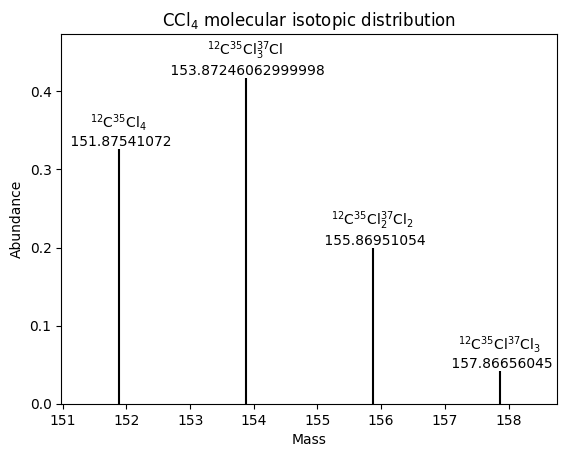

In [115]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='Mass', y='Abundance', data=df_pandas, marker='')

plt.xlabel('Mass')
plt.ylabel('Abundance')

formula = smiles_to_formatted_formula(sml, isotopes=True)["latex"]

# Use C-style string formatting with the % operator to avoid conflicts with using braces for both LaTeX and {}.format()
title = r"${\rm %s}$ molecular isotopic distribution" % (formula.strip("$"))

plt.title(title)

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df_pandas['Mass']) - min(df_pandas['Mass'])
xpad = xrange * 0.15
plt.xlim(min(df_pandas['Mass']) - xpad, max(df_pandas['Mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df_pandas['Abundance']) - min(df_pandas['Abundance'])
ypad = yrange * 0.15
plt.ylim(0, max(df_pandas['Abundance']) + ypad)

for index, (mass, abundance, formula) in enumerate(zip(df_pandas['Mass'], df_pandas['Abundance'], df_pandas['Formula_latex'])):
    # Add vertical lines from each data point to the x-axis
    plt.vlines(x=mass, ymin=0, ymax=abundance, colors='black')
    # Label the data points by mass
    label = r"${\rm %s}$ %s %s" % (formula.strip("$"), "\n", mass)
    plt.text(
        x=mass, 
        y=abundance, 
        s=label, 
        ha='center',
        va='bottom')

plt.show()

## Conclusion

That's it for this approach. Again, creating a molecule for each permutation is computationally expensive, so in part 2 I'll share a more sophisticated and tractable approach using combinations.

*Acknowledgement: I thank my late father [Robert Monat](https://www.arnmortuary.com/obituary/Robert-Monat) for teaching me about combinations vs. permutations.*